In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import re

In [21]:
# Load Excel file
df = pd.read_excel("Resume_dataset.xlsx")
df.head()

,Education_Level,Experience_Years,Skills_Matched,Certifications,GPA_or_CGPA,No_of_Projects,Job_Internship_Count,Hackathons_Competitions,GitHub_URL_Present,LinkedIn_URL_Present,Email_Present,Professional_Keywords_Count,Resume_Rank
0,Bachelors,5,4,0,3.297264,1,0,0,0,1,1,6,4.55
1,PhD,1,3,0,3.901146,3,2,0,0,1,1,8,4.42
2,Bachelors,2,2,2,3.702443,2,0,2,0,1,0,6,4.36
3,Bachelors,4,1,0,3.077255,4,0,0,1,1,1,1,2.69
4,Bachelors,4,4,3,3.154408,1,2,1,0,1,1,5,7.60


In [22]:
# Encode 'Education_Level' to numeric
edu_encoder = LabelEncoder()
df['Education_Level'] = edu_encoder.fit_transform(df['Education_Level'])

# Check if all values are numeric now
df.dtypes


Education_Level                  int64
Experience_Years                 int64
Skills_Matched                   int64
Certifications                   int64
GPA_or_CGPA                    float64
No_of_Projects                   int64
Job_Internship_Count             int64
Hackathons_Competitions          int64
GitHub_URL_Present               int64
LinkedIn_URL_Present             int64
Email_Present                    int64
Professional_Keywords_Count      int64
Resume_Rank                    float64
dtype: object

In [23]:
# Features (X) and Target (y)
X = df.drop('Resume_Rank', axis=1)
y = df['Resume_Rank']

In [24]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R² Score: 0.26667590665592333
MSE: 1.6106959346287328


In [25]:
# Save trained model and encoder
joblib.dump(model, "resume_ranker_model.pkl")
joblib.dump(edu_encoder, "education_encoder.pkl")

['education_encoder.pkl']

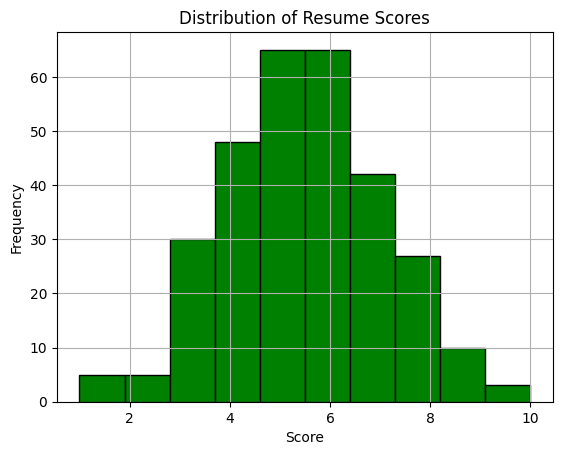

In [26]:
plt.hist(df["Resume_Rank"], bins=10, color='green', edgecolor='black')
plt.title("Distribution of Resume Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [27]:
import os
import fitz  # for PDF
import docx  # for DOCX

# Load model and encoder
import joblib
model = joblib.load("resume_ranker_model.pkl")
edu_encoder = joblib.load("education_encoder.pkl")

from dateutil import parser
from datetime import datetime

# === Resume Reader ===
def read_resume(file_path):
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".txt":
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    elif ext == ".pdf":
        text = ""
        with fitz.open(file_path) as pdf:
            for page in pdf:
                text += page.get_text()
        return text
    elif ext == ".docx":
        doc = docx.Document(file_path)
        return "\n".join(p.text for p in doc.paragraphs)
    else:
        raise ValueError("Unsupported file type")

# === Enhanced Experience Extractor ===
def extract_years_from_text(text):
    text = text.lower()
    total_months = 0

    # General date range pattern
    matches = re.findall(r'([a-z]{3,9})\s+(\d{4})\s*[-–]\s*([a-z]{3,9}|present|current)\s*(\d{4})?', text)
    matches = matches[:2]  # Only consider first 2 date ranges (optional)

    for start_month, start_year, end_month, end_year in matches:
        try:
            start_date = parser.parse(f"{start_month} {start_year}")
            if end_month in ["present", "current"] or not end_year:
                end_date = datetime.today()
            else:
                end_date = parser.parse(f"{end_month} {end_year}")
            months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
            if months > 0:
                total_months += months
        except:
            continue

    return round(total_months / 12, 1)


# === Feature Extractor ===
def extract_features(text):
    text = text.lower()

    # Education
    if "phd" in text:
        edu = "PhD"
    elif "master" in text:
        edu = "Masters"
    elif "bachelor" in text:
        edu = "Bachelors"
    elif "associate" in text:
        edu = "Associate"
    else:
        edu = "High School"

    # Experience
    exp = extract_years_from_text(text)

    # Skills
    skills_list = ["python", "sql", "java", "c++", "html", "css", "javascript",
                   "machine learning", "ai", "tensorflow", "software", "data analyst",
                   "developer", "project management"]
    skills = sum(skill in text for skill in skills_list)

    # Other features
    certs = len(re.findall(r'certified|certification', text))
    gpa = float(re.search(r'(\d\.\d{1,2})', text).group(1)) if re.search(r'(\d\.\d{1,2})', text) else 3.0
    projects = len(re.findall(r'project', text))
    jobs = len(re.findall(r'internship|intern|worked at|experience at', text))
    hack = len(re.findall(r'hackathon|competition|contest', text))
    github = 1 if "github.com" in text else 0
    linkedin = 1 if "linkedin.com" in text else 0
    email = 1 if re.search(r'\S+@\S+\.\S+', text) else 0
    prof_words = sum(word in text for word in ["developed", "led", "collaborated", "built", "managed"])

    return pd.DataFrame([{
        "Education_Level": edu_encoder.transform([edu])[0],
        "Experience_Years": exp,
        "Skills_Matched": skills,
        "Certifications": certs,
        "GPA_or_CGPA": gpa,
        "No_of_Projects": projects,
        "Job_Internship_Count": jobs,
        "Hackathons_Competitions": hack,
        "GitHub_URL_Present": github,
        "LinkedIn_URL_Present": linkedin,
        "Email_Present": email,
        "Professional_Keywords_Count": prof_words
    }])


In [30]:
import os
import re
import fitz
import docx
import pandas as pd

folder_path = "Resume upload"  # Your folder with resumes

for file in os.listdir(folder_path):
    if file.endswith((".pdf", ".txt", ".docx")):
        try:
            path = os.path.join(folder_path, file)
            text = read_resume(path)
            features = extract_features(text)
            score = model.predict(features)[0]

            # Decode Education
            edu_value = edu_encoder.inverse_transform([features['Education_Level'][0]])[0]

            print(f"\n📄 {file}: 🎯 Resume Rank = {score:.2f}\n")
            print("📌 Reason:")
            print(f"- ✅ Education: {edu_value}")
            print(f"- 🧠 Experience: {features['Experience_Years'][0]} years")
            print(f"- 🛠 Skills Matched: {features['Skills_Matched'][0]}")
            print(f"- 🎓 Certifications: {features['Certifications'][0]}")
            print(f"- 📚 GPA/CGPA: {features['GPA_or_CGPA'][0]}")
            print(f"- 💼 Projects: {features['No_of_Projects'][0]}")
            print(f"- 👨‍💼 Internships/Jobs: {features['Job_Internship_Count'][0]}")
            print(f"- ⚔️ Hackathons: {features['Hackathons_Competitions'][0]}")
            print(f"- 🔗 GitHub: {'Present' if features['GitHub_URL_Present'][0] else 'Missing'}")
            print(f"- 🔗 LinkedIn: {'Present' if features['LinkedIn_URL_Present'][0] else 'Missing'}")
            print(f"- 📧 Email: {'Present' if features['Email_Present'][0] else 'Missing'}")
            print(f"- 💬 Professional Keywords: {features['Professional_Keywords_Count'][0]}")

            # 🔍 Suggestions
            suggestions = []

            if features['Skills_Matched'][0] < 4:
                suggestions.append("Add more technical skills related to the field")
            if features['Certifications'][0] == 0:
                suggestions.append("Include relevant certifications")
            if features['GitHub_URL_Present'][0] == 0:
                suggestions.append("Include a GitHub link to showcase projects")
            if features['LinkedIn_URL_Present'][0] == 0:
                suggestions.append("Add a LinkedIn profile for better visibility")
            if features['Hackathons_Competitions'][0] < 1:
                suggestions.append("Participate in hackathons to show initiative")
            if features['No_of_Projects'][0] < 2:
                suggestions.append("Add more personal or academic projects")
            if features['GPA_or_CGPA'][0] < 3.0:
                suggestions.append("If possible, improve GPA or highlight strong skills/projects")

            if suggestions:
                print("\n💡 Suggestions to Improve Resume:")
                for s in suggestions:
                    print(f"- {s}")
            else:
                print("\n✅ Great resume! No major improvements needed.")

        except Exception as e:
            print(f"{file}: ❌ Error - {e}")



📄 Blue Simple Professional CV Resume.pdf: 🎯 Resume Rank = 2.73

📌 Reason:
- ✅ Education: Masters
- 🧠 Experience: 0.0 years
- 🛠 Skills Matched: 2
- 🎓 Certifications: 0
- 📚 GPA/CGPA: 3.8
- 💼 Projects: 1
- 👨‍💼 Internships/Jobs: 0
- ⚔️ Hackathons: 0
- 🔗 GitHub: Missing
- 🔗 LinkedIn: Missing
- 📧 Email: Present
- 💬 Professional Keywords: 0

💡 Suggestions to Improve Resume:
- Add more technical skills related to the field
- Include relevant certifications
- Include a GitHub link to showcase projects
- Add a LinkedIn profile for better visibility
- Participate in hackathons to show initiative
- Add more personal or academic projects

📄 IT Manager CV Resume.pdf: 🎯 Resume Rank = 5.84

📌 Reason:
- ✅ Education: Masters
- 🧠 Experience: 5.9 years
- 🛠 Skills Matched: 3
- 🎓 Certifications: 0
- 📚 GPA/CGPA: 3.26
- 💼 Projects: 8
- 👨‍💼 Internships/Jobs: 0
- ⚔️ Hackathons: 0
- 🔗 GitHub: Present
- 🔗 LinkedIn: Present
- 📧 Email: Present
- 💬 Professional Keywords: 3

💡 Suggestions to Improve Resume:
- Add mo

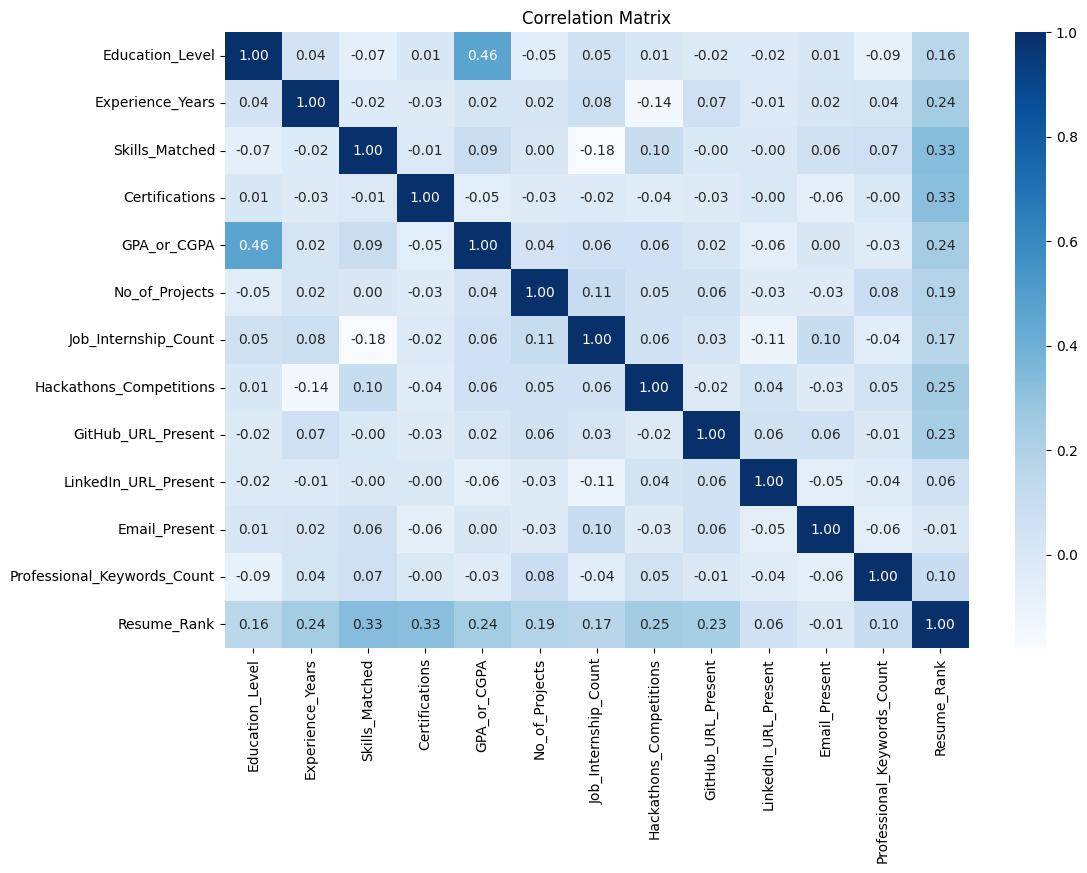

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
correlation = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()